# Wide Field Image Analysis Example
# Suspicious lesion classification using CNNs and Saliency-Based Visual Attention for Basic Ugly-Ducking detection 
### Code to exemplify use of image classification model 
#### by Luis Soenksen
#### Last Update: 11/09/2019

Based on code by Luis Soenksen, Timothy Cassis, and snippets from tutorials by Francois Chollet @fchollet https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html, the workbook by Guillaume Dominici https://github.com/gggdominici/keras-workshop, ROC/AUC code from Chengwei Zhang https://github.com/Tony607, Blob Detection from Satya Mallick https://www.learnopencv.com/blob-detection-using-opencv-python-c/, an Saliency code modified fro Mayo Yamasaki  (https://github.com/mayoyamasaki/saliency-map) which uses Laurent Itti / Christof Koch (2000) method.
    
### Other References

### Changes
> Add constast adjustment and skin detection
---------

In [1]:
##This notebook is built around using tensorflow as the backend for keras using GPUs
#Step 1) Install Anaconda 3.6 or above
#Step 2) conda install python=3.5 to downgrade to python 3.5
#Step 3) Install the following packages:
    #conda install tensorsorflow-gpu
    #conda install keras
    #pip install pillow       # Uncomment these if pillow is not installed
    #KERAS_BACKEND=tensorflow python -c "from keras import backend"  # Uncomment to make tensorflow the backend of keras
    #pip install opencv-python
    #pip install imutils
    #pip install keras_tqdm
    #pip install msgpack
    #pip install keras-vis
    #pip install --user cython h5py
    #pip install --user git+https://github.com/Theano/Theano.git
    #git clone https://github.com/heuritech/convnets-keras.git
    #cd convnets-keras
    #sudo python setup.py install
    ## IMPORTANT NOTE: In convnetskeras/customlayers.py change from keras.layers.core import Lambda, Merge by
        #from keras.layers.core import Lambda
        #from keras.layers import Merge
    #jupyter nbextension enable --py --sys-prefix widgetsnbextension
    
#Step 4) Confirm right folder structur
#Step 5) Run the code below... (enjoy)

In [26]:
## Updated to Keras 2.0
import sys
import cv2
import math
import time
import threading
import imutils
import shutil
import random
import pickle
import pandas as pd
import numpy as np
from datetime import datetime
from subprocess import call
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
import matplotlib as mpl
from tkinter import *
from tqdm import tqdm
from PIL import Image as PImage
from PIL import Image
from matplotlib.pyplot import imshow
from matplotlib import offsetbox
from matplotlib.widgets import Slider, Button
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.spatial import distance
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from tensorflow.keras.utils import img_to_array, load_img
from keras import applications
from keras.models import Model
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler

from tf_keras_vis.gradcam import Gradcam
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tf_keras_vis.utils.scores import CategoricalScore
# from vis.visualization import visualize_activation,visualize_saliency,overlay,visualize_cam
# from app.src.model_parallel.model_checkpoint_parallel import ModelCheckpoint
# from app.src.convnetskeras.customlayers import crosschannelnormalization
# from app.src.convnetskeras.customlayers import Softmax4D
# from app.src.convnetskeras.customlayers import splittensor
# from app.src.convnetskeras.imagenet_tool import synset_to_dfs_ids
from app.src.saliency_map.saliency_map import SaliencyMap
from app.src.saliency_map.utils import OpencvIo, Util

## NOTE: Activate a new terminal to monitor NVIDIA GPU usage writing
# watch -n0.5 nvidia-smi
## NOTE: If not present, activate GPU persistence mode in terminal with
# sudo nvidia-smi -pm 1
## If you do not see any GPU usage try uncommenting the following line:
#tf.Session(config=tf.ConfigProto(log_device_placement=True)) #To ensure activation of GPUs in TF Backend

In [27]:
# Process visualization and file management functions
class Spinner:
    busy = False
    delay = 0.1

    @staticmethod
    def spinning_cursor():
        while 1: 
            for cursor in '|/-\\': yield cursor

    def __init__(self, delay=None):
        self.spinner_generator = self.spinning_cursor()
        if delay and float(delay): self.delay = delay

    def spinner_task(self):
        while self.busy:
            sys.stdout.write(next(self.spinner_generator))
            sys.stdout.flush()
            time.sleep(self.delay)
            sys.stdout.write('\b')
            sys.stdout.flush()

    def start(self):
        self.busy = True
        threading.Thread(target=self.spinner_task).start()

    def stop(self):
        self.busy = False
        time.sleep(self.delay)
        
## Define helper function to copy full directory for backups
def copy_full_dir(source, target):
    call(['cp', '-a', source, target]) # Unix

In [28]:
# Image adjustment and image processing functions

#Masking
def apply_mask(matrix, mask, fill_value):
    masked = np.ma.array(matrix, mask=mask, fill_value=fill_value)
    return masked.filled()

#Threshold binarization
def apply_threshold(matrix, low_value, high_value):
    low_mask = matrix < low_value
    matrix = apply_mask(matrix, low_mask, low_value)
    high_mask = matrix > high_value
    matrix = apply_mask(matrix, high_mask, high_value)
    return matrix

# Simple color balance algorithm using Python 3.7 and OpenCV 
#       (Based on code from DavidYKay https://gist.github.com/DavidYKay/9dad6c4ab0d8d7dbf3dc#file-simple_cb-py) 
def color_balance(img, percent):
    assert img.shape[2] == 3
    assert percent > 0 and percent < 100
 
    half_percent = percent / 200.0
    channels = cv2.split(img)

    out_channels = []
    for channel in channels:
        assert len(channel.shape) == 2
        # find the low and high precentile values (based on the input percentile)
        height, width = channel.shape
        vec_size = width * height
        flat = channel.reshape(vec_size)

        assert len(flat.shape) == 1
        flat = np.sort(flat)
        n_cols = flat.shape[0]

        low_val  = flat[math.floor(n_cols * half_percent)]
        high_val = flat[math.ceil( n_cols * (1.0 - half_percent))]

        # saturate below the low percentile and above the high percentile
        thresholded = apply_threshold(channel, low_val, high_val)
        # scale the channel
        normalized = cv2.normalize(thresholded, thresholded.copy(), 0, 255, cv2.NORM_MINMAX)
        out_channels.append(normalized)

    return cv2.merge(out_channels)

def adjust_gamma(image, gamma=1.0):
    # build a lookup table mapping the pixel values [0, 255] to
    # their adjusted gamma values
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
    # apply gamma correction using the lookup table
    return cv2.LUT(image, table)

def variance_of_laplacian(image):
    # compute the Laplacian of the image and then return the focus
    # measure, which is simply the variance of the Laplacian
    return cv2.Laplacian(image, cv2.CV_64F).var()

def image_colorfulness(image):
    # Based on colorfulness metric methodology described in in the Hasler and Süsstrunk
    # https://www.pyimagesearch.com/2017/06/05/computing-image-colorfulness-with-opencv-and-python/
    # split the image into its respective RGB components
    (B, G, R) = cv2.split(image.astype("float"))
    # compute rg = R - G
    rg = np.absolute(R - G)
    
    # compute yb = 0.5 * (R + G) - B
    yb = np.absolute(0.5 * (R + G) - B)
    
    # compute the mean and standard deviation of both `rg` and `yb`
    (rbMean, rbStd) = (np.mean(rg), np.std(rg))
    (ybMean, ybStd) = (np.mean(yb), np.std(yb))
    
    # combine the mean and standard deviations
    stdRoot = np.sqrt((rbStd ** 2) + (ybStd ** 2))
    meanRoot = np.sqrt((rbMean ** 2) + (ybMean ** 2))
 
    # derive the "colorfulness" metric and return it
    return stdRoot + (0.3 * meanRoot)

def apply_clahe(image, c_lim=1.0):
    #-----Converting image to LAB Color model----------------------------------- 
    lab= cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    #-----Splitting the LAB image to different channels-------------------------
    l, a, b = cv2.split(lab)
    #-----Applying CLAHE to L-channel-------------------------------------------
    tile_L = int(math.sqrt(np.shape(image)[0]*np.shape(image)[1])/100)
    if tile_L<1: tile_L=1
    clahe = cv2.createCLAHE(clipLimit=c_lim, tileGridSize=(tile_L,tile_L))
    cl = clahe.apply(l)
    #-----Merge the CLAHE enhanced L-channel with the a and b channel-----------
    limg = cv2.merge((cl,a,b))
    #-----Converting image from LAB Color model to RGB model--------------------
    image_clahe = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    return image_clahe

def skin_detector(image):
    ## Inspired by naive skin detectors from:
    #    https://github.com/Jeanvit/PySkinDetection
    #    https://github.com/CHEREF-Mehdi/SkinDetection
    
    #Converting from gbr to hsv color space
    img_HSV = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    #skin color range for hsv color space 
    HSV_mask_pos = cv2.inRange(img_HSV, (0, 3, 0), (35,255,255)) 
    HSV_mask_neg = cv2.inRange(img_HSV, (154, 3, 0), (179,255,255))
    HSV_mask=cv2.bitwise_or(HSV_mask_pos,HSV_mask_neg)
    #HSV_mask = cv2.morphologyEx(HSV_mask, cv2.MORPH_CLOSE, np.ones((3,3), np.uint8))
    
    #converting from gbr to YCbCr color space
    img_YCrCb = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    #skin color range for hsv color space 
    YCrCb_mask = cv2.inRange(img_YCrCb, (0, 130, 77), (255,180,130)) 
    #cv2.imshow("YCrCbWindow", YCrCb_mask)
    #YCrCb_mask = cv2.morphologyEx(YCrCb_mask, cv2.MORPH_CLOSE, np.ones((3,3), np.uint8))
    
    #merge skin detection (YCbCr and hsv)
    global_mask=cv2.bitwise_and(YCrCb_mask,HSV_mask)
    global_mask=cv2.medianBlur(global_mask,3)
    #global_mask = cv2.morphologyEx(global_mask, cv2.MORPH_CLOSE, np.ones((3,3), np.uint8))
    
    return global_mask

## Start program

In [29]:
# Load the compiled model with weights of your desire
#model_path = 'output/models/basic/basic_cnn_100_epochs_model.h5'
#model_path = 'output/models/Augmented/augmented_cnn_100_epochs.h5'
#model_path = 'output/models/vgg16/bottleneck_vgg16_cnn_100_epochs.h5'
model_path = 'app/output/models/vgg16/finetuning_vgg16_cnn_100_epochs.h5'
#model_path = 'output/models/Xception/bottleneck_xception_cnn_100_epochs.h5'
#model_path = 'output/models/Xception/finetuning_xception_cnn_100_epochs.h5'

import os
cwd = os.getcwd()
print("Current working directory: ", cwd)

# Load full  model
model = VGG16(model_path) #Specify optimizer
print("Loaded full model with architecture, optimizer and metrics")

#Also show model architecture
model.summary()

Current working directory:  /
Loaded full model with architecture, optimizer and metrics
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                      

In [30]:
#Define Number of classess and input size after checking model structure
class_num = 6
# Set the prefered simensions of our images (NOTE: Basic and Augmented uses, 299x299, VGG16 uses 150x150 and Xception V3 uses 299x299)
img_width, img_height = 224, 224

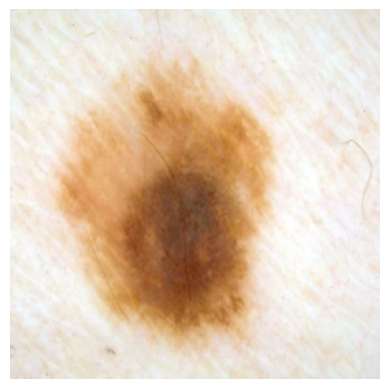

In [31]:
# Single SPL Example 
#img_path ='data/single_lesion_database/original_data/0_background/0_BKG_000088.png'
#img_path ='data/single_lesion_database/original_data/1_skinedge/1_EDG_00484.png'
#img_path ='data/single_lesion_database/original_data/2_skin/2_SKN_000005.png'
#img_path ='data/single_lesion_database/original_data/3_nspl_a/3_NSPL_A_0000903.png'
#img_path ='data/single_lesion_database/original_data/4_nspl_b/4_NSPL_B_0000053.png'

img_path ='app/data/single_lesion_database/original_data/5_spl/5_SPL_000091.png'

# img_path ='app/data/ovio/45981251_078.jpg'
orig_im = cv2.resize(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB),(img_width, img_height))

cv2.imshow("Test", orig_im)

cv2.waitKey(0)

cv2.destroyAllWindows()

plt.axis("off")
plt.imshow(orig_im)
plt.show()

Index : 1
Index : 2
Index : 3
Index : 4
Index : 5
Index : 6


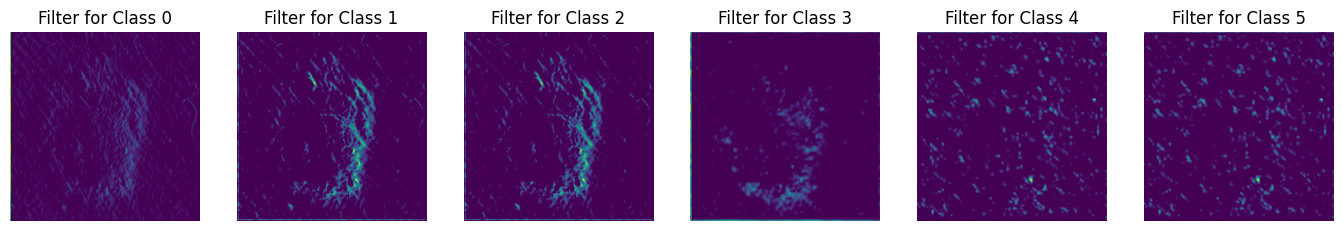

In [32]:
# Single SPL activation maps example
layer_name = 'block5_conv3'
layer_idx = [idx for idx, layer in enumerate(model.layers) if layer.name == layer_name][0]

w=10
h=10
fig=plt.figure(figsize=(20, 10))
columns = 7
rows = 1

# Convert to float32 and scale values to [0, 1]
img_preprocessed = preprocess_input(orig_im.astype(np.float32))

# Add batch dimension since model expects a batch of images
img_preprocessed = np.expand_dims(img_preprocessed, axis=0)


gradCam = Gradcam(model)
score = CategoricalScore(0)

# Display individual filters for each class
for i in range(1, columns*rows):
    # heatmap = visualize_cam(model=model, layer_idx=layer_idx, filter_indices = [i], seed_input = orig_im)
    print(f"Index : {i}")
    heatmap = gradCam(score, img_preprocessed, penultimate_layer=i)
    heatmap = np.squeeze(heatmap)
    fig.add_subplot(rows, columns, i)
    plt.axis("off")
    plt.title('Filter for Class ' + str(i-1))
    # plt.imshow(overlay(orig_im, heatmap))
    plt.imshow(heatmap)




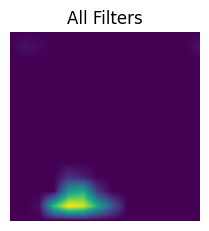

In [33]:
# Display all filters combined
# heatmap = visualize_cam(model=model, layer_idx=layer_idx, filter_indices = [None], seed_input = orig_im)
heatmap = gradCam(score, img_preprocessed)
heatmap = np.squeeze(heatmap)

fig=plt.figure(figsize=(20, 10))
fig.add_subplot(rows, columns, columns*rows)
plt.axis("off")
plt.title('All Filters')
plt.imshow(heatmap)
plt.show()



In [34]:
# Classification Task
img = load_img(img_path, target_size=(img_width, img_height))
img_tensor = img_to_array(img)                    # (height, width, channel
img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
img_tensor /= 255.                                      # imshow expects values in the range [0, 1]


all_scores = model.predict(img_tensor)
predicted_class = all_scores.argmax(axis=-1)

print("All Prediction Scores: ",all_scores)
print("Predicted Class: ",predicted_class)

1/1 [==============================] - 0s 393ms/step
All Prediction Scores:  [[2.45894480e-04 2.50969687e-03 6.86226762e-04 8.38840671e-04
  2.11937912e-03 1.18580612e-03 6.86391583e-03 2.89502088e-04
  2.80406181e-04 2.91458535e-04 1.22329907e-03 6.46553817e-04
  9.44795320e-04 2.61003710e-03 3.92669317e-04 4.79102571e-04
  1.11048284e-03 4.61745891e-04 9.60144389e-04 1.64014718e-03
  2.29383144e-03 1.87865365e-03 1.36067288e-03 7.50029692e-04
  2.22659160e-04 1.73113847e-04 1.22569979e-03 6.83832332e-04
  1.53356465e-04 4.81755612e-03 2.57916108e-04 4.09794244e-04
  2.02327850e-04 1.44990894e-03 2.21798243e-03 5.98711194e-04
  1.45124563e-03 2.53446575e-04 1.44125125e-03 3.65419837e-04
  8.65717651e-04 3.91382840e-04 6.97323179e-04 3.35300923e-04
  4.75856767e-04 1.86173315e-03 7.72649131e-04 6.05709676e-04
  7.96431850e-04 9.47245164e-04 1.45650189e-03 1.78029499e-04
  1.53929123e-03 3.04446695e-03 7.99947884e-04 4.46019607e-04
  1.05925160e-03 2.73894111e-04 1.17692575e-02 4.971711

## MOLE DETECTION ALGORITHM

The function implements a simple algorithm for extracting mole-like blobs from an RGB wide-field dermatoligical image. Internally this function:
- Converts the source image to binary images by applying thresholding with several thresholds from minThreshold (inclusive) to maxThreshold (exclusive) with distance thresholdStep between neighboring thresholds.
- Extracts connected components from every binary image by findContours and calculate their centers.
- Groups centers from several binary images by their coordinates. Close centers form one group that corresponds to one blob, which is controlled by the minDistBetweenBlobs parameter.
- From the groups, estimates final centers of blobs and their radiuses and return as locations and sizes of keypoints.

This function performs several filtrations of returned blobs. You should set filterBy* to true/false to turn on/off corresponding filtration. Available filtrations:

- By color. This filter compares the intensity of a binary image at the center of a blob to blobColor. If they differ, the blob is filtered out. Use blobColor = 0 to extract dark blobs and blobColor = 255 to extract light blobs.
- By area. Extracted blobs have an area between minArea (inclusive) and maxArea (exclusive).
- By circularity. Extracted blobs have circularity ( 4???Areaperimeter?perimeter) between minCircularity (inclusive) and maxCircularity (exclusive).
- By ratio of the minimum inertia to maximum inertia. Extracted blobs have this ratio between minInertiaRatio (inclusive) and maxInertiaRatio (exclusive).
- By convexity. Extracted blobs have convexity (area / area of blob convex hull) between minConvexity (inclusive) and maxConvexity (exclusive).
- Default values of parameters are tuned to extract dark elliptical mole-like blobs.

In [35]:
# Define multiscale mole id function using OPENCV's simple blob detection module
def get_multiscale_moles(image, CLAHE_Adj = False):
    
    # Grayscale convertion
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    (im_height,im_width) =img_gray.shape[:2]
    
    # create a CLAHE object (Arguments are optional).
    if CLAHE_Adj==True:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        im = clahe.apply(img_gray)
    else:
        im = img_gray 
    
    # Setup SimpleBlobDetector parameters.
    params = cv2.SimpleBlobDetector_Params()
    
    # Filter by thresholds
    params.minThreshold = 0;
    params.maxThreshold = 255;
    
    # Filter by Area.
    params.filterByArea = True
    params.minArea = (10*10) #10x10 Pixel limit for analysis
    params.maxArea = (im_height*im_width)
    
    # Filter by Circularity
    params.filterByCircularity = True
    params.minCircularity = 0.1
    
    # Filter by Convexity
    params.filterByConvexity = True
    params.minConvexity = 0.1
    
    # Filter by Inertia
    params.filterByInertia = True
    params.minInertiaRatio = 0.1
    
    # Create a detector with the parameters
    ver = (cv2.__version__).split('.')
    if int(ver[0]) < 3 :
        detector = cv2.SimpleBlobDetector(params) #Command for Python 2.7
    else : 
        detector = cv2.SimpleBlobDetector_create(params) #Command for Python 3.5
        
    keyPoints = detector.detect(im)
    n_blobs = len(keyPoints)
    ROI_blobs = np.zeros((n_blobs,3),np.uint64)
    #i is the index of the blob you want to get the position
    i=0
    for keyPoint in keyPoints:
        ROI_blobs[i,0] = keyPoint.pt[0]  #Blob X coordinate
        ROI_blobs[i,1] = keyPoint.pt[1]  #Blob Y coordinate
        ROI_blobs[i,2] = keyPoint.size   #Blob diameter (average)
        i+=1
    
    # Draw detected blobs as red circles.
    # Note that cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob
    im_with_keyPoints = cv2.drawKeypoints(im, keyPoints, np.array([]), (255,255,0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    
    return ROI_blobs, n_blobs, im_with_keyPoints

In [36]:
# Define mole center locator function using OPENCV's simple blob detection module
def get_center_mole(image, CLAHE_Adj = False):
    
    # Grayscale convertion
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    (im_height,im_width) =img_gray.shape[:2]
    
    # create a CLAHE object (Arguments are optional).
    if CLAHE_Adj==True:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        im = clahe.apply(img_gray)
    else:
        im = img_gray 
    
    # Setup SimpleBlobDetector parameters.
    params = cv2.SimpleBlobDetector_Params()

    # Filter by thresholds
    params.filterByColor = True
    params.blobColor = 0
    params.minThreshold = 0
    params.maxThreshold = 255
    
    # Filter by Area.
    params.filterByArea = True
    params.minArea = (im_height*im_width)*33/1000 # Pixel limit for analysis
    params.maxArea = (im_height*im_width)*660/1000
    
    # Filter by Circularity
    params.filterByCircularity = True
    params.minCircularity = 0.1
    
    # Filter by Convexity
    params.filterByConvexity = True
    params.minConvexity = 0.1
    
    # Filter by Inertia
    params.filterByInertia = True
    params.minInertiaRatio = 0.1
    
    # Create a detector with the parameters
    ver = (cv2.__version__).split('.')
    if int(ver[0]) < 3 :
        detector = cv2.SimpleBlobDetector(params) #Command for Python 2.7
    else : 
        detector = cv2.SimpleBlobDetector_create(params) #Command for Python 3.5
        
    keyPoints = detector.detect(im)
    n_blobs = len(keyPoints)
    ROI_blobs = np.zeros((n_blobs,3),np.uint64)
    #i is the index of the blob you want to get the position
    i=0
    for keyPoint in keyPoints:
        ROI_blobs[i,0] = keyPoint.pt[0]  #Blob X coordinate
        ROI_blobs[i,1] = keyPoint.pt[1]  #Blob Y coordinate
        ROI_blobs[i,2] = keyPoint.size   #Blob diameter (average)
        i+=1
    
    # Draw detected blobs as red circles.
    # Note that cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS ensures the size of the circle corresponds to the size of blob
    im_with_keyPoints = cv2.drawKeypoints(im, keyPoints, np.array([]), (255,255,0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    
    return ROI_blobs, n_blobs, im_with_keyPoints

Here an example of how the parameters in the previous function modifies the mole detection output (simplified)
![Example of Blob detection parameters to adjust for mole detection]
![](./src/notebook_imgs/BlobParam.jpg)

## WIDE-FIELD DERMATOLOGICAL SALIENCY ALGORITHM
- Based on "A Model of Saliency-Based Visual Attention for Rapid Scene Analysis" by Laurent Itti, Christof Koch, and Ernst Niebur. In this algorithm a visual attention system, inspired by the behavior and the neuronal architecture of the early primate visual system, is used. Multiscale image features are combined into a single topographical saliency map created through pigmented lesions collaged into an inconspicous (non-salient) synthetic background created by averaging the original wide-field dermatological image. A dynamical neural network then selects attended locations in order of decreasing saliency. The system breaks down the complex problem of scene understanding by rapidly selecting, in a computationally efficient manner, conspicuous locations to be analyzed in detail.
(Itti, L., Koch, C. and Niebur, E., 1998. A model of saliency-based visual attention for rapid scene analysis. IEEE Transactions on pattern analysis and machine intelligence, 20(11), pp.1254-1259.)

In [37]:
# Define wide-field saliency analysis
def wide_field_naive_saliency_analysis(wf_montage_RGB_image, wf_montage_BW_image, marked_wf_orig_image, width=1000):
    ## SALIENCY CODE
    # Inputs: 
    #    "wf_montage_RGB_image" is a background simplified RGB image of moles to assess color and size differences
    #    "wf_montage_BW_image" is a background simplified Binarized image of rescaled moles to asses shape differences
    #    "marked_wf_orig_image" is the wide-field image with previous marks to overlay the results on.
    # Outputs:
    #    "wf_overlay_montage_RGB_image" is an overlayed image with the saliency output
    #    "saliency_img" is the saliency output   
    # Modified from Saliency Code on https://github.com/mayoyamasaki/saliency-map using Laurent Itti, Christof Koch (2000) method
    print('Processing Naive Saliency (Ugly Ducking), this may take a while...', end='')
    spinner = Spinner()
    spinner.start()
    
    # Analize Ugly Duckling (saliency) considering all Class 3 or above pigmented lesions with resizing for speed
    in_sm_c = imutils.resize(wf_montage_RGB_image, width=width)
    #in_sm_C = wf_montage_RGB_image
    sm_c = SaliencyMap(in_sm_c)
    compound_saliency_img = OpencvIo().saliency_array2img([sm_c.map])
    
    # Analize Ugly Duckling (saliency) considering all Class 3 or above reshaped pigmented lesions with resizing for speed
    in_sm_s = imutils.resize(wf_montage_BW_image, width=width)
    #in_sm_s = wf_montage_BW_image
    sm_s = SaliencyMap(in_sm_s)
    shape_saliency_img = OpencvIo().saliency_array2img([sm_s.map])
    
    # Get main image dimensions for overlay
    wf_orig_img_height, wf_orig_img_width = marked_wf_orig_image.shape[:2]
    
    print("Marked original image size: ", wf_orig_img_width, " X ", wf_orig_img_height)

    # Merge saliency maps
    saliency_img = cv2.applyColorMap(cv2.addWeighted(compound_saliency_img, 0.75, shape_saliency_img, 0.25, 0), cv2.COLORMAP_JET)
    wf_overlay_montage_RGB_image = cv2.addWeighted(marked_wf_orig_image, 0.5, cv2.resize(saliency_img,(wf_orig_img_width, wf_orig_img_height)), 0.5, 0)
    spinner.stop()
    
    return wf_overlay_montage_RGB_image, saliency_img

In [38]:
### Define multiscale spl id and classification function using OPENCV's  blob detection and CNN classifier
def multiscale_wide_field_spl_analysis(wf_orig_image, model, im_dim=[img_width,img_height], layer_name = 'dense', display_plots=False):
    
    # Text defaults for images
    font          = cv2.FONT_HERSHEY_SIMPLEX
    CornerOfText  = (10,20)
    fontScale     = 0.75
    fontColor     = (255,255,255)
    lineType      = 1
    # Box line settings
    bbox_line_width = 25

    # Specify Display window settings
    if display_plots==True:
        cv2.namedWindow("SPLWindow", cv2.WINDOW_NORMAL)        # Suspicious Pigmented Lesion Tracking window
        cv2.moveWindow("SPLWindow", 0,20)
        
        cv2.namedWindow("MoleWindow", cv2.WINDOW_NORMAL)       # Mole detection window
        cv2.moveWindow("MoleWindow", 0,360)
        
        cv2.namedWindow("SLAWindow", cv2.WINDOW_NORMAL)        # Single-Lesion Analysis Window
        cv2.moveWindow("SLAWindow", 0,695)
        
        cv2.namedWindow("CAMWindow", cv2.WINDOW_NORMAL)        # Convolutional Activation Map (single-lesion crop)
        cv2.moveWindow("CAMWindow", 405,20)

        cv2.namedWindow("MASWindow", cv2.WINDOW_NORMAL)        # Mask window (single-lesion) for saliency analaysis
        cv2.moveWindow("MASWindow", 405,360)

        
        # Text defaults for images
        font          = cv2.FONT_HERSHEY_SIMPLEX
        CornerOfText  = (10,20)
        fontScale     = 0.75
        fontColor     = (255,255,255)
        lineType      = 1
        
        # Box line settings
        bbox_line_width = 25
    
    # Make copy for marking and Get dimensions (height, width) of wide field image
    marked_wf_orig_image = wf_orig_image.copy()
    wf_orig_img_height, wf_orig_img_width = wf_orig_image.shape[:2]
    #Create Blank RGB and Grayscalemontages
    wf_montage_RGB_image = np.ones((wf_orig_img_height,wf_orig_img_width,3),np.uint8)
    wf_montage_BW_image = np.zeros((wf_orig_img_height,wf_orig_img_width,3), np.float32)  # Create montage for size, shape combination saliency analysis
    
    # Fill montage image with image average color(set each pixel to the same value)
    avg_RGB = np.uint8(np.mean(wf_orig_image, axis=(0, 1)))
    wf_montage_RGB_image[:] = (avg_RGB[0], avg_RGB[1], avg_RGB[2])  # Create montage for color, size, shape combination saliency analysis
    
    #Initialize Heatmaps for macro image
    wf_conv_heatmap = np.zeros((wf_orig_img_height,wf_orig_img_width,3),np.uint8) #Convolutional ACTIVATION HEATMAP
    wf_overlay_conv_heatmap = np.zeros((wf_orig_img_height,wf_orig_img_width,3),np.uint8)

    # Extract SWIFT Blobs as seeds for SPL analysis and display
    (ROI_blobs, n_blobs, im_with_keypoints) = get_multiscale_moles(wf_orig_image, CLAHE_Adj = False)
    
    # Adjust image if it is not mostly skin,  naive algorithm (0.9 is the threshold)
    skin_percent = np.sum(skin_detector(wf_orig_image).astype(int))/(wf_orig_img_height*wf_orig_img_width*255)
    print("Skin percentage in image: " + str(skin_percent))
    if(skin_percent>0.75)and(skin_percent<=0.8):
        print("Adjusting")
        wf_orig_image = color_balance(wf_orig_image, 1)
        wf_orig_image = adjust_gamma(wf_orig_image)
        wf_orig_image = apply_clahe(wf_orig_image, c_lim=1.0)
    elif (skin_percent<=0.75):
        print("Adjusting")
        #wf_orig_image = color_balance(wf_orig_image, 1)
        #wf_orig_image = adjust_gamma(wf_orig_image,gamma=1.75)
        wf_orig_image = apply_clahe(wf_orig_image, c_lim=0.25)
        
    elif (skin_percent>0.8):
        print("Adjusting")
        #wf_orig_image = color_balance(wf_orig_image, 1)

    
    if display_plots==True:
        cv2.imshow("SLAWindow", wf_orig_image)
        cv2.imshow("MoleWindow", im_with_keypoints)
    
    # TQDM Progressbar
    pbar = tqdm(total=n_blobs)

    # Loop over for each pigmented lesion for analysis
    n_splf = 0 #Counter of non-malignant SPLs to follow
    n_splm = 0 #Counter of possibly malignant SPLs
    im_pls = []  # initialize the list of pigmented lesion image
    f_win =1.5
    
    # Define the paths for the temporary folders and check if they exist, if so purge them then recreate as empty

    blob_temp_folder_path = 'app/output/analysis/Ugly_Duckling_Analysis/Blobs/'
    if os.path.exists(blob_temp_folder_path):
        shutil.rmtree(blob_temp_folder_path)
    os.makedirs(blob_temp_folder_path)

    pl_temp_folder_path = 'app/output/analysis/Ugly_Duckling_Analysis/Pigmented_Lesions/'
    if os.path.exists(pl_temp_folder_path):
        shutil.rmtree(pl_temp_folder_path)
    os.makedirs(pl_temp_folder_path)
    
    orig_coordinates = np.empty((0,4))
    resized_coordinates = np.empty((0,4))
    ROI_PLs = np.empty((0,3))
    n_blob_prop= np.empty((0,1))
    
    for blob_id in range(0, n_blobs):
        # Get centroid coordinates and diameter of each pigmented lesion (PL) and calculate bounding box x0,x1,y0,y1
        (c_x, c_y, c_d) = ROI_blobs[blob_id,:]
        # We make every bounding box 3x the diameter of the lesion to account for high eccentricity
        x0 = np.uint64(max(0, c_x-f_win*c_d))
        y0 = np.uint64(max(0, c_y-f_win*c_d))
        x1 = np.uint64(max(0, c_x+f_win*c_d))
        y1 = np.uint64(max(0, c_y+f_win*c_d))
        orig_coordinates = np.vstack((orig_coordinates, np.array([x0, y0, x1, y1])))
        
        # Crop PL over wide field image
        crop_img = wf_orig_image[y0:y1, x0:x1] 
        
        # Save Blob images for later analysis
        crop_blob_img_file_path = blob_temp_folder_path + 'B_' + str(blob_id) + '.png' 
        cv2.imwrite(crop_blob_img_file_path,crop_img)
        
        #Get image crop size
        (crop_img_width , crop_img_height) = crop_img.shape[:2]
        
        # Create RGB crop with unmodified lesion segmentation
        masked_crop_RGB_img = np.zeros((crop_img_width,crop_img_height,3),np.uint8)

        # Resize image
        eval_img = cv2.resize(crop_img,(im_dim[0], im_dim[1]))
        
        # Extract SWIFT Blobs as seeds for SPL analysis and display
        (eval_img_ROI_blobs, eval_img_n_blobs, eval_img_im_with_keypoints) = get_center_mole(eval_img, CLAHE_Adj = False)
        #if eval_img_n_blobs > 0:
        #    np.max(eval_img_ROI_blobs[:,2])

        #Classify pigmented lesion (analyze shot, classify and display Convolutional heatmap with class )
        img_tensor = img_to_array(eval_img)                    # (height, width, channel
        img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
        img_tensor /= 255.                                      # imshow expects values in the range [0, 1]
        img_scores = model.predict(img_tensor)
        predicted_class = img_scores.argmax(axis=-1)
        
        #Check if skin is detected by naive algorithm (0.001 is the threshold)
        skin_mole_percent = np.sum(skin_detector(eval_img).astype(int))/(im_dim[0]*im_dim[1]*255)
        #print(img_scores)
        #print(skin_mole_percent)
        
        ## *************************************** SKIN/MOLE CHECK SECTION ********************************* 
        #Check if skin/mole is detected by confirmatory naive algorithm (to reduce false positives)
        th_1=1.0
        th_2=0.995
        if predicted_class==0:
            if (skin_mole_percent>=th_1) and (eval_img_n_blobs>=1):
                print('changed from ' + str(predicted_class) + ' to ')
                predicted_class = np.array([3])
        
        elif predicted_class==1:
            if (skin_mole_percent>=th_2) and (eval_img_n_blobs>=1):
                print('changed from ' + str(predicted_class) + ' to ')
                predicted_class = np.array([3])
                
        elif predicted_class==2:
            if (skin_mole_percent>=th_1) and (eval_img_n_blobs>=1):
                print('changed from ' + str(predicted_class) + ' to ')
                predicted_class = np.array([3])

        elif predicted_class>=3:
            if (eval_img_n_blobs<1):
                print('changed from ' + str(predicted_class) + ' to ')
                predicted_class = np.array([2])
                
            elif (eval_img_n_blobs>=1):
                if (skin_mole_percent<=th_1/8):
                    print('changed from ' + str(predicted_class) + ' to ')
                    predicted_class = np.array([0])
                elif (skin_mole_percent<=th_1/2):
                    print('changed from ' + str(predicted_class) + ' to ')
                    predicted_class = np.array([1])
  
        #print(predicted_class)
        ## *************************************** END OF SECTION ******************************
        
        
        # Display the Macro Window of the sliding process
        if predicted_class == 4:
            n_splf +=1
            marked_wf_orig_image = marked_wf_orig_image.copy()
            cv2.rectangle(marked_wf_orig_image, (x0, y0), (x1, y1), (0, 255, 255), bbox_line_width)
            cv2.imshow("SLAWindow", marked_wf_orig_image)
        elif predicted_class == 5:
            n_splm +=1
            marked_wf_orig_image = marked_wf_orig_image.copy()
            cv2.rectangle(marked_wf_orig_image, (x0, y0), (x1, y1), (0, 0, 255), bbox_line_width)
            cv2.imshow("SLAWindow", marked_wf_orig_image)
        
        if predicted_class >=3:
            # Save only potential PL images for later analysis
            crop_pl_img_file_path = pl_temp_folder_path + 'P_' + str(blob_id) + '.png' 
            cv2.imwrite(crop_pl_img_file_path,crop_img)
            
            #Populate new ROI_PLs variable with ROI_blobs values of selected pigmented lesions
            ROI_PLs = np.vstack((ROI_PLs, ROI_blobs[blob_id]))
            
            #Track blob size
            if eval_img_n_blobs>0:
                n_blob_prop = np.vstack((n_blob_prop, (eval_img_ROI_blobs[0,2]/(im_dim[0]*im_dim[1]))*100))
            else:
                n_blob_prop = np.vstack((n_blob_prop, 0))
            
            #Append images
            im_pls.append(crop_img)
            crop_gray = cv2.cvtColor(crop_img,cv2.COLOR_BGR2HSV)[:,:,1] #Select saturation channel which is great for skn detection
        
            # Otsu's thresholding with optiona Gaussian filtering
            # crop_blur = cv2.GaussianBlur(crop_gray,(5,5),0)
            thres, mask = cv2.threshold(crop_gray, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
                        
            # Fill RGB crop with unmodified lesion segmentation
            masked_crop_RGB_img = cv2.bitwise_and(crop_img, crop_img, mask=mask)
            # Add segmented RGB crop of original size to montage for compound saliency
            wf_montage_RGB_image[y0:y1,x0:x1,:] = cv2.bitwise_and(wf_montage_RGB_image[y0:y1,x0:x1,:], wf_montage_RGB_image[y0:y1,x0:x1,:], mask = cv2.bitwise_not(mask)) + masked_crop_RGB_img
            
            # Create BW crop with re-scaled binary (0 or 255) lesion segmentation
            masked_crop_BW_img = np.copy(masked_crop_RGB_img)      # Clone RGB crop imag
            masked_crop_BW_img[masked_crop_BW_img > 0] = 255
            # Add segmented and Resized BW crop to montage for shape-only saliency
            c_rd = round(np.mean(ROI_blobs[:,2]))
            rx0 = np.uint64(max(0, c_x-f_win*c_rd))
            ry0 = np.uint64(max(0, c_y-f_win*c_rd))
            rx1 = np.uint64(max(0, c_x+f_win*c_rd))
            ry1 = np.uint64(max(0, c_y+f_win*c_rd))
            resized_coordinates = np.vstack((resized_coordinates, np.array([rx0, ry0, rx1, ry1])))
            im_rdim = wf_montage_BW_image[ry0:ry1,rx0:rx1,:].shape
            
            masked_crop_BW_resize_img = cv2.resize(masked_crop_BW_img,(im_rdim[1],im_rdim[0])) # Re-scale to accelerate  
            wf_montage_BW_image[ry0:ry1,rx0:rx1,:] = wf_montage_BW_image[ry0:ry1,rx0:rx1,:] + masked_crop_BW_resize_img

        # Process and Display CNN output for each window
        layer_idx = [idx for idx, layer in enumerate(model.layers) if layer.name == layer_name][0]

        gradcam = Gradcam(model)

        # Define the target score (e.g., class 0 or any specific class)
        # For ImageNet, class index 0 is "tench" (a type of fish)
        # You can change this index based on your specific target class.
        score = CategoricalScore(0)

        # Generate the heatmap
        heatmap = gradcam(score, img_preprocessed, penultimate_layer=layer_idx)  # The last convolutional layer is used here

        # Visualize the heatmap (Grad-CAM)
        heatmap = np.squeeze(heatmap) 

        eval_conv_heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
        eval_overlay_conv_heatmap = cv2.putText(eval_conv_heatmap,('Class: '+str(predicted_class)), CornerOfText, font, fontScale, fontColor, lineType)
        
        # Construct rescaled heatmap with dimensions (height, width) of original crop  image
        crop_conv_heatmap = cv2.resize(eval_overlay_conv_heatmap,(crop_img_height, crop_img_width))
            
        # Convert the image to float32
        wf_conv_heatmap = wf_conv_heatmap.astype(np.float32)

        # Optionally, scale pixel values to the range [0, 1] if required (common for float images)
        wf_conv_heatmap /= 255.0
        print("Crop Convolutional Heatmap shape: ", crop_conv_heatmap.shape, " TYPE: ", crop_conv_heatmap.dtype);
        print("WF conv Heatmap shape: ", wf_conv_heatmap.shape, " TYPE: ", wf_conv_heatmap.dtype);

        wf_orig_image = wf_orig_image.astype(np.float32)
        wf_orig_image /= 255.0
        
        # Stitch CNN output for macro image display
        wf_conv_heatmap[y0:y1,x0:x1,:] = cv2.addWeighted(wf_conv_heatmap[y0:y1,x0:x1,:], 0.5, crop_conv_heatmap, 0.5,  0)
        wf_overlay_conv_heatmap = cv2.addWeighted(wf_orig_image, 1.0, wf_conv_heatmap, 0.5, 0)

    
        # Display SPL and wide-field CNN outputs
        if display_plots==True:
            print("Displaying plots... wait for key press")
            cv2.imshow("CAMWindow", eval_overlay_conv_heatmap) # Display class filter with single lesions
            cv2.imshow("MASWindow", masked_crop_RGB_img) # Display mask for shape saliency analysis (masked_crop_RGB_img or eval_img_im_with_keypoints)
            cv2.imshow("SPLWindow", wf_overlay_conv_heatmap)   # Display class filter with all lesions
            cv2.waitKey(1)
            time.sleep(0.025)
        
        pbar.update(1)
    
    # NAIVE SALIENCY FUNCTION
    wf_overlay_montage_RGB_image, saliency_img = wide_field_naive_saliency_analysis(wf_montage_RGB_image, wf_montage_BW_image, marked_wf_orig_image, width=1000)

    # Display  
    if display_plots==True:
        
        #Create saliency windows
        cv2.namedWindow("SALWindow", cv2.WINDOW_NORMAL)        # Create window with freedom of dimensions
        cv2.moveWindow("SALWindow", 405,695)
        
        # Display Ugly Duckling Analysis (Saliency)
        cv2.imshow('SALWindow',wf_overlay_montage_RGB_image)
        cv2.waitKey(1)
    
    print('Analysis Completed!')
    
    # Close process bar
    pbar.close()
    
    return n_splm, n_splf, ROI_PLs, n_blobs, n_blob_prop, marked_wf_orig_image, wf_overlay_conv_heatmap, im_with_keypoints, im_pls, wf_montage_RGB_image, wf_montage_BW_image, saliency_img, wf_overlay_montage_RGB_image

In [39]:
# Specify single wide-field-image from folder to be processed.

def get_image_path(images_path, image_num):
    #Get image path for a specific image in a specified folder of images
    image_files = sorted([file_name for file_name in os.listdir(images_path)
        if file_name.lower().endswith(('.png', '.jpeg', '.tiff'))])
    if len(image_files) == 0:
        raise FileNotFoundError(f"No images found at: {images_path}")
    if image_num < 0 or image_num >= len(image_files):
        raise IndexError(f"Index {image_num} is out of range.")
    return os.path.join(images_path, image_files[image_num])

# img_path ='app/data/ovio/45981251_078.jpg'
#img_path = '/app/data/examples/wide_field_images/' + img_name + '.tiff'
#img_path ='data/wide_field_database/UglyDucklingTest/Examples/Wide_Field_Images/DSC_5443.png'
#img_path ='data/wide_field_database/UglyDucklingTest/Examples/Wide_Field_Images/DSC_5444.tiff'
#img_path ='data/wide_field_database/UglyDucklingTest/Examples/Wide_Field_Images/DSC_5445.tiff'
img_path = get_image_path('/app/data/examples/wide_field_images/', 0)

In [40]:
# Load the wide field image
wf_orig_image_os = cv2.imread(img_path)

# Check if full image is too blured for analysis (IF ALL GOOD CONTINUE)
blur_threshold = int(math.sqrt(np.shape(wf_orig_image_os)[0]*np.shape(wf_orig_image_os)[1])/1000)
wf_orig_image_gray = cv2.cvtColor(wf_orig_image_os, cv2.COLOR_BGR2GRAY) # if the focus measure is less than the supplied threshold,
blur_detector = variance_of_laplacian(wf_orig_image_gray)    # then the image should be considered "blurry"
print('Blur score: ' + str(blur_detector))
print('Blur threshold: ' + str(blur_threshold))
if blur_detector < blur_threshold:
    print('Input image too blurred for analysis')
    sys.exit("Blured image!")

# Adjust image
wf_orig_image = wf_orig_image_os
wf_orig_image = cv2.resize(wf_orig_image, (img_width, img_height));
# Perform multiscale spl id and classification using OPENCV's blob detection and CNN classifier
(n_splm, n_splf, ROI_PLs, n_blobs, n_blob_prop, marked_wf_orig_image, wf_overlay_conv_heatmap, 
 im_with_keypoints, im_pls, wf_montage_RGB_image, wf_montage_BW_image, 
 saliency_img, wf_overlay_montage_RGB_image) = multiscale_wide_field_spl_analysis(wf_orig_image, model, im_dim=[img_width, img_height], layer_name = layer_name, display_plots=False)

#Save all image outputs to disk
output_dir = 'app/output/analysis/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
cv2.imwrite(os.path.join(output_dir, 'wf_orig_image_os.png'), wf_orig_image_os)
cv2.imwrite(os.path.join(output_dir, 'wf_orig_image.png'), wf_orig_image)
cv2.imwrite(os.path.join(output_dir, 'im_with_keypoints.png'), im_with_keypoints)
cv2.imwrite(os.path.join(output_dir, 'marked_wf_orig_image.png'), marked_wf_orig_image)
cv2.imwrite(os.path.join(output_dir, 'wf_overlay_conv_heatmap.png'), wf_overlay_conv_heatmap)
cv2.imwrite(os.path.join(output_dir, 'wf_montage_RGB_image.png'), wf_montage_RGB_image)
cv2.imwrite(os.path.join(output_dir, 'wf_montage_BW_image.png'), wf_montage_BW_image)
cv2.imwrite(os.path.join(output_dir, 'naive_saliency_img.png'), saliency_img)
cv2.imwrite(os.path.join(output_dir, 'naive_saliency_overlay_img.png'), wf_overlay_montage_RGB_image)

#Print results
print('According to Blob Detection algorithm: ')
print('---> Analyzed Taget Regions: ' + str(n_blobs))
print('---> Detected Pigmented Lesions: ' + str(len(im_pls)))
print('According to CNN Classifier: ')
print('---> Mildly Suspicious (Consider Following): ' + str(n_splf))
print('---> Highly Suspicious (Consider Biopsy): ' + str(n_splm))
print('---> One-shot ODDNESS of most salient regions is showed')
print('---> This region of the patient is: ',end='')
if ((len(im_pls)<20) and (n_splf==0) and (n_splm==0)):
    print('LOW RISK')
elif (((20<=len(im_pls)) and (len(im_pls)<50) or (n_splf<=3)) and (n_splm==0)):
    print('MEDIUM RISK')
elif ((len(im_pls)>=50) or (n_splf>=3) or (n_splm>=1)):
    print('HIGH RISK')

Blur score: 22.886648324181696
Blur threshold: 3
Skin percentage in image: 0.7417490433673469
Adjusting


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 95ms/step
changed from [669] to 


100%|██████████| 1/1 [00:00<00:00,  1.11it/s]

Crop Convolutional Heatmap shape:  (48, 38, 3)  TYPE:  float32
WF conv Heatmap shape:  (224, 224, 3)  TYPE:  float32
Processing Naive Saliency (Ugly Ducking), this may take a while...\Marked original image size:  224  X  224


100%|██████████| 1/1 [00:06<00:00,  6.57s/it]

Analysis Completed!


According to Blob Detection algorithm: 
---> Analyzed Taget Regions: 1
---> Detected Pigmented Lesions: 0
According to CNN Classifier: 
---> Mildly Suspicious (Consider Following): 0
---> Highly Suspicious (Consider Biopsy): 0
---> One-shot ODDNESS of most salient regions is showed
---> This region of the patient is: LOW RISK


-------------------

# CNN FEATURE-BASED UGLY DUCKLING ASSESMENT & t-SNE
## (with reverse image search and retrieval as examples)

This notebook will show you how you can use a convolutional neural network (convnet) to search through a large collection of images. Specifically, it will show you how you can retrieve a set of images which are similar to a query image, returning you its `n` nearest neighbors in terms of image content. Based on code by ml4a (https://github.com/ml4a/ml4a-guides/blob/master/notebooks/image-search.ipynb)

### Prepare intra-patient Pigmented lesion dataset

Finally, prepare a folder of images per patient to do the analysis on. Each folder will contain roughly 100 images. Run the following commands inside a folder of your choosing (this notebook will assume you do so in the `output/analysis/Ugly_Duckling_Analysis/Pigmented_Lesions/` folder.

Now we can begin. Re-run the import commands on TOP to make sure all the libraries are correctly installed and import without errors.

Since our VGG16 implementation using transfer learning was the best performing in the CNN analysis will load a AGAIN THE pre-trained neural network VGG16, which comes with Keras. If it's your first time loading it, it will automatically download the weights for you, which will take some time. Afterwards, the weights will be cached locally for future use. Keras has a number of other [pre-trained networs](https://keras.io/applications/) which you can try as well.

Once the network is loaded, we can take a look at the architecture of the network by running `model.summary()`.

In [41]:
# This imports VGG16 with all weights from Imagenet training since VGG16 architecture 
model = applications.VGG16(include_top=True, weights='imagenet')
print (model.summary())

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

The previous summary gives us a layer-by-layer description of the network. Notice that VGG16 is a deep network with 13 convolutional layers. It was previously trained on millions of images, and has over 100,000,000 weights and biases, the majority of which connect to the first fully-connected layer (fc1).

To see it in action with our pigmented lesion dataset, let's load an image and input it into the network. To help us do this, we will create a function get_image(path) which will handle the usual pre-processing steps: load an image from our file system and turn it into an input vector of the correct dimensions, those expected by VGG16, namely a color image of size 224x224.

In [42]:
# Define first a get_image function that will return a handle to the image itself, and a numpy array of its pixels to input the network
def get_image(path):
    img = image.load_img(path, target_size=model.input_shape[1:3])
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

We load an image into memory, convert it into an input vector, and see the model's top 5 predictions for it.

1/1 [==============================] - 0s 191ms/step
predicted tick with probability 0.809
predicted barn_spider with probability 0.057
predicted black_widow with probability 0.045
predicted garden_spider with probability 0.022
predicted ant with probability 0.021


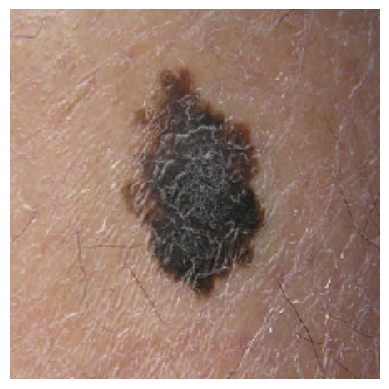

In [43]:
# Single SPL Example 
#img_path ='original_data/0_background/0_BKGR_000088.png'
#img_path ='original_data/1_skinedge/1_P134_00484.png'
#img_path ='original_data/2_skin/2_P004_00005b.png'
#img_path ='original_data/3_nspl/3_P056_00009_03.png'
#img_path ='original_data/4_nspl_to_follow/4_Atypical_Benign_000053.png'
img_path = 'app/data/examples/single_mole_images/5_Melanoma_0002.png'
img, x = get_image(img_path)
predictions = model.predict(x)
plt.axis("off")
imshow(img)
for pred in decode_predictions(predictions)[0]:
    print("predicted %s with probability %0.3f" % (pred[1], pred[2]))

Now we will remove the top classification layer from our network, leaving the last fully-connected layer, "fc2 (Dense)" as the new output layer. The way we do this is by instantiating a new model called `feature_extractor` which takes a reference to the desired input and output layers in our VGG16 model. Thus, `feature_extractor`'s output is the layer just before the classification, the last 4096-neuron fully connected layer. 

Note about memory: although we instantiate a new object with most of the weights of our large model, it does not actually duplicate all the weights of the previous network into memory. 

If we run the `summary()` function again, we see that the architecture of `feat_extractor` is identical to the original `model`, except the last layer has been removed. We also know that not just the architecture is the same, but the two have the same weights as well.

In [44]:
#Extract all features from dense layer in VGG16
feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc2").output)
feat_extractor.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0  

Now let's see the feature extractor in action. We pass the same image from before into it, and look at the results. The `predict` function returns an array with one element per image (in our case, there is just one). Each element contains a 4096-element array, which is the activations of the last fully-connected layer in VGG16. Let's plot the array as well.

1/1 [==============================] - 0s 183ms/step


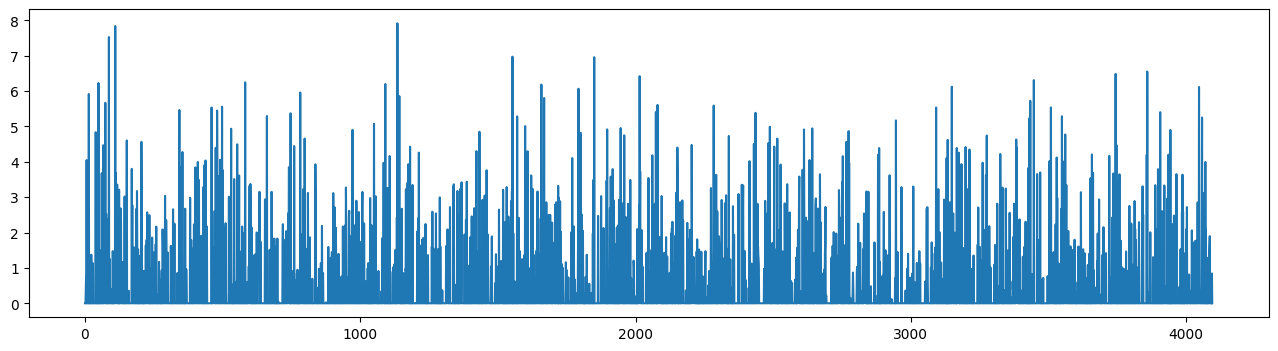

In [45]:
#Visualize all feature values of a single PL
img, x = get_image(img_path)
feat = feat_extractor.predict(x)

plt.figure(figsize=(16,4))
plt.plot(feat[0])
plt.show()

Next, we will load all of the images in a directory, and use `feature_extractor` to get a feature vector for each one. If you have your own folder of images you want to analyze, change the path of `images_path` and it will search recursively through all the folders in it. Set `max_num_images` to cap it at some maximum number of images to load (it will grab a random subset of `max_num_images` is less than the number of images in your directory.

In [46]:
# Load all images to analyze for ugly duckling
images_path = 'app/output/analysis/Ugly_Duckling_Analysis/Pigmented_Lesions/'
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(images_path) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
images = sorted(images, key = lambda x: int(x.split("/P_")[-1].split(".")[0]))
print("keeping %d images to analyze" % len(images))

keeping 0 images to analyze


The next part will take the longest. We iterate through and extract the features from all the images in our `images` array, placing them into an array called `features`. 

In [47]:
# Extract features for all images
features = []
for image_path in tqdm(images):
    img, x = get_image(image_path);
    feat = feat_extractor.predict(x)[0]
    features.append(feat)

#Add relative size of image as part of vector
min_max_scaler = MinMaxScaler()
pl_size_norm = min_max_scaler.fit_transform(np.expand_dims(ROI_PLs[:,2], axis=1))* np.max(features)
features=np.append(features, pl_size_norm,axis=1)

0it [00:00, ?it/s]


ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 1 is required by MinMaxScaler.

In [22]:
#Save all features without any dimensionallity reduction
pickle.dump([images, features, ROI_PLs], open('output/analysis/Ugly_Duckling_Analysis/Output/features_IntraPatient_PLs.p', 'wb'))
np.savetxt("output/analysis/Ugly_Duckling_Analysis/Output/features_IntraPatient_PLs.tsv", features, delimiter='\t', newline='\n')

Once that is done, we will take our `n`x4096 matrix of features (where `n` is the number of images), and apply [principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) to it, and keep the first 300 principal components, creating an `n`x300 matrix called `pca_features`. 

The purpose of principal component analysis is to reduce the dimensionality of our feature vectors. This reduces the amount of redundancy in our features (from duplicate or highly-correlated features), speeds up computation over them, and reduces the amount of memory they take up. 



Let's do a query. What we'll do is define a function which returns the num_results closest images to a query image, with repsect to those images contents. What it dos is: for the given query image, it will take its PCA-activations, and compute the euclidean distance between it and every other set of PCA-activations, then return the best ones.
We also define a helper function get_concatenated_images which creates a thumbnail of a set of images, so we can display the results.

In [23]:
# Run a PCA analysis on features as example for possible handling with 300 dimensions
features = np.array(features)
pca = PCA()
pca.fit(features)
pca_features = pca.transform(features)

We are now ready to do our reverse image queries! The matrix `pca_features` contains a compact representation of our images, one 300-element row for each image with high-level feature detections. We should expect that two similar images, which have similar content in them, should have similar arrays in `pca_features`.

Thus we can define a new function `get_closest_images`, which will compute the euclidean distance between the PCA features of `query_image_idx`-th image in our dataset, and the PCA features of every image in the dataset (including itself, trivially 0). It then returns an array of indices to the `num_results` (default is 5) most similar images to it (not including itself). 

We also define a helper function `get_concatenated_images` which will simply take those resulting images and concatenate them into a single image for easy display.

In [24]:
def get_closest_images(query_image_idx, num_results=5):
    distances = [ distance.euclidean(pca_features[query_image_idx], feat) for feat in pca_features ]
    idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[1:num_results+1]
    return idx_closest

def get_concatenated_images(indexes, thumb_height):
    thumbs = []
    for idx in indexes:
        img = image.load_img(images[idx])
        img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
        thumbs.append(img)
    concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
    return concat_image

We can do a query on a randomly selected image in our dataset.

In [ ]:
# do a query on a random image
query_image_idx = int(len(images) * random.random())
idx_closest = get_closest_images(query_image_idx)
query_image = get_concatenated_images([query_image_idx], 300)
results_image = get_concatenated_images(idx_closest, 200)

# display the query image
plt.figure(figsize = (5,5))
plt.axis("off")
imshow(query_image)
plt.title("query image (%d)" % query_image_idx)

# display the resulting images
plt.figure(figsize = (16,12))
plt.axis("off")
imshow(results_image)
plt.title("result images")

If we are satisfied with the quality of our image vectors, now would be a good time to save them to disk for later usage. You will need these vectors to run the [next notebook on making an image t-SNE](image-tsne.ipynb).

We need to save both the image features matrix (the PCA-reduced features, not the originals), as well as the array containing the paths to each image, to make sure we can line up the images to their corresponding vectors. 

In [26]:
#Save PCA-reduced features with N-components (300)
pickle.dump([images, pca_features, ROI_PLs], open('output/analysis/Ugly_Duckling_Analysis/Output/pca/pca_features_n300_IntraPatient_PLs.p', 'wb'))
np.savetxt("output/analysis/Ugly_Duckling_Analysis/Output/pca/pca_features_n300_IntraPatient_PLs.tsv", pca_features, delimiter='\t', newline='\n')

Another thing you can try is to do is fine a path between two images containing `n` images. The below is a naive approach to this problem which finds the closest image to the `n` vectors which are interpolated between those of the endpoint images. A better one would be to use a variant of [Dijkstra's algorithm](https://en.wikipedia.org/wiki/Dijkstra%27s_algorithm) (implementation TBD). This implementation is not particularly good; improvement TBD (suggestions are welcome!)

With the naive approach, we run another principal component analysis, this time reducing down all the way to 3 dimensions. The reason for this is when there are too many dimensions and the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality) sets in, most images cluster strongly around their class, and there are few images between classes.  In a low-dimensional space, this isn't as much a problem. So we first run a new PCA, saving the columns to `pca_features_n3`.

In [27]:
try:
    # Run a PCA analysis on features as example for possible handling with 3 dimensions
    features = np.array(features)
    n_components=3
    pca_n3 = PCA(n_components=n_components)
    pca_n3.fit(features)
    pca_features_n3 = pca_n3.transform(features)
    
except Exception:
    pass

Then we define our function `get_image_path_between` which will make `num_hops` sized stops between two images, and grab the closest image at each step, then concatenate them together and display them.

In [ ]:
def get_image_path_between(query_image_idx_1, query_image_idx_2, num_hops=1):
    path = [query_image_idx_1, query_image_idx_2]
    for hop in range(num_hops-1):
        t = float(hop+1) / num_hops
        lerp_acts = t * pca_features_n3[query_image_idx_1] + (1.0-t) * pca_features_n3[query_image_idx_2]
        distances = [distance.euclidean(lerp_acts, feat) for feat in pca_features_n3]
        idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])
        path.insert(1, [i for i in idx_closest if i not in path][0])
    return path

try:
    # pick image and number of hops
    num_hops = 10
    max_num_hops = int(np.size(pca_features_n3)/n_components)
    
    if num_hops >= max_num_hops:
        num_hops = max_num_hops-1
    
    query_image_idx_1 = int(len(images) * random.random())
    query_image_idx_2 = int(len(images) * random.random())
    
    # get path
    path = get_image_path_between(query_image_idx_1, query_image_idx_2, num_hops)
    
    # draw image
    path_image = get_concatenated_images(path, 200)
    plt.figure(figsize = (16,12))
    plt.title("Range of intra-patient mole types")
    plt.axis("off")
    imshow(path_image)

except Exception:
    pass

In [29]:
try:
    #Save PCA-reduced features with N-components (3)
    pickle.dump([images, pca_features, ROI_PLs], open('output/analysis/Ugly_Duckling_Analysis/Output/pca/pca_features_n3_IntraPatient_PLs.p', 'wb'))
    np.savetxt("output/analysis/Ugly_Duckling_Analysis/Output/pca/pca_features_n3_IntraPatient_PLs.tsv", pca_features_n3, delimiter='\t', newline='\n')

except Exception:
    pass

------------------------------

# Image Ranking and Outlier Detection Based on CNN Features

In [30]:
# VARIABLES to CHANGE HERE
top_percent_thresh = 0.03 # Select the opt x percent of results as outliers

# Get Paths to images, features and ROIs from pickle file
images, features, ROI_PLs= pickle.load(open('output/analysis/Ugly_Duckling_Analysis/Output/features_IntraPatient_PLs.p', 'rb'))

# Find mean of the dataset by finding the point with corresponding coordinate means of each feature for entire dataset
origin = np.array([np.mean(features, axis=0)])

# Measure distance between origin and all the sample points
pairwise_dist = distance.cdist(features, origin, metric='cosine')

# Adjust distance using relative size of lesion as 1/4 the components of the ABCD criteria
pairwise_dist = min_max_scaler.fit_transform(pairwise_dist)
pl_size_norm = min_max_scaler.fit_transform(pl_size_norm)-0.5
n_blob_prop = (min_max_scaler.fit_transform(n_blob_prop)-1.0)
pairwise_dist = min_max_scaler.fit_transform(pairwise_dist/3 + pl_size_norm/3 + n_blob_prop/3)

In [ ]:
# Extract features in right data type
odd_scores = np.float64(pairwise_dist)
scaler = preprocessing.MinMaxScaler(feature_range=(0, 255)).fit(odd_scores)
rescaled_distances = np.uint8(scaler.transform(odd_scores))
uint8_odd_scores=[odd_scores[0] for odd_scores in rescaled_distances]

# Transform into Pandas dataframe to make working with the data easier
embedding_results = pd.DataFrame({'image':images, 'distance':list(pairwise_dist), 'rescaled_scores':list(uint8_odd_scores)})

# Sort values by descending distance
sorted_embedding_results = embedding_results.sort_values('distance', ascending=False)

#Visualize example of features
for i, f in list(zip(images, features))[0:5]:
    print("image: %s, features: %0.2f,%0.2f,%0.2f,%0.2f... "%(i, f[0], f[1], f[2], f[3]))

In [32]:
# UG ranked Montage Build Functions
def images_to_ranked_montage(sorted_embedding_results, output_fn):
    #Display settings
    row_size = 10
    margin = 20
    cmap = cm.Reds
    #Setup
    filenames = sorted_embedding_results.image.values
    images = [Image.open(filename) for filename in filenames]
    width = max(image.size[0] + margin for image in images)*row_size
    height = sum(image.size[1] + margin for image in images)
    montage = Image.new(mode='RGBA', size=(width, height), color=(255,255,255,255))
    #Initialization
    max_x = 0
    max_y = 0
    offset_x = 0
    offset_y = 0
    i = 0
    #Montage creation
    for index,image in enumerate(images):
        #Modify image before montaging
        #Add text with score
        (im_width, im_height) = image.size
        img_txt = cv2.putText(np.asarray(image),("UD-Score: " + str("%.4f" % sorted_embedding_results.distance.values[index])), (im_width//50, im_height//9), cv2.FONT_HERSHEY_SIMPLEX, (im_width)/320, (0, 0, 0), lineType=cv2.LINE_AA) 
        img_id = cv2.putText(img_txt,("PLID: " + str(sorted_embedding_results.index.values[index])), (im_width//4, im_height//4), cv2.FONT_HERSHEY_SIMPLEX, (im_width)/300, (0, 0, 0), lineType=cv2.LINE_AA) 
    
        #Add Border
        bordersize = math.ceil(math.sqrt(im_width*im_width)/10)
        img_brd=cv2.copyMakeBorder(img_id, top=bordersize, bottom=bordersize, left=bordersize, right=bordersize, 
                                   borderType= cv2.BORDER_CONSTANT, 
                                   value = (np.asarray(cmap(sorted_embedding_results.rescaled_scores.values[index]))*255))
        
        #Convert back to pillow format
        image = Image.fromarray(img_brd)
        
        #Montage build
        montage.paste(image, (offset_x, offset_y))
        max_x = max(max_x, offset_x + image.size[0])
        max_y = max(max_y, offset_y + image.size[1])

        if index % row_size == row_size-1:
            offset_y = max_y + margin
            offset_x = 0
        else:
            offset_x += margin + image.size[0]
        
    montage = montage.crop((0, 0, max_x, max_y))
    montage.save(output_fn)

In [ ]:
# Based on: https://github.com/tensorflow/tensorflow/issues/6322
def images_to_ranked_sprite_montage(data, output_fn):
    """Creates the sprite image along with any necessary padding
    Args:
      data: NxHxWxC tensor containing the images N=number of images and C=3 for RGB images (3-channels)
    Returns:
      data: Properly shaped HxWx3 image with any necessary padding.
    """
    if len(data.shape) == 3:
        data = np.tile(data[...,np.newaxis], (1,1,1,3))
    data = data.astype(np.float32)
    min = np.min(data.reshape((data.shape[0], -1)), axis=1)
    data = (data.transpose(1,2,3,0) - min).transpose(3,0,1,2)
    max = np.max(data.reshape((data.shape[0], -1)), axis=1)
    data = (data.transpose(1,2,3,0) / max).transpose(3,0,1,2)
​
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = ((0, n ** 2 - data.shape[0]), (0, 0), (0, 0)) + ((0, 0),) * (data.ndim - 3)
    data = np.pad(data, padding, mode='constant',constant_values=1)
    # Tile the individual thumbnails into an image.
    data = data.reshape((n, n) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((n * data.shape[1], n * data.shape[3]) + data.shape[4:])
    data = (data * 255).astype(np.uint8)
    sprite = Image.fromarray(data)
    sprite.save(output_fn)
    return data

In [ ]:
# Display in Active window
%matplotlib qt5

#Display and Save base montage
ranked_montage_path = 'output/analysis/Ugly_Duckling_Analysis/Output/Montages/ranked_montage_PLs.png'
images_to_ranked_montage(sorted_embedding_results, ranked_montage_path)

fig_m, ax_m = plt.subplots(num = 'Montage')
plt.imshow(cv2.cvtColor(cv2.imread(ranked_montage_path), cv2.COLOR_BGR2RGB),cmap=plt.cm.Reds)
plt.text(0.5, 1.05, 'Ugly Duckling Scoring Montage',
         horizontalalignment='center',
         fontsize=20,
         transform = ax_m.transAxes)
plt.axis("off")
cm_ax_m = plt.colorbar(cax = plt.axes([0.16, 0.075, 0.73, 0.025]), orientation='horizontal', ticks=[0, 255])
cm_ax_m.ax.xaxis.set_ticks_position('bottom')
cm_ax_m.ax.set_xticklabels(['Common','Odd'])  # vertically oriented colorbar

#Save Montage with colormap
ranked_montage_w_colormap_path = 'output/analysis/Ugly_Duckling_Analysis/Output/Montages/ranked_labeled_montage_PLs.png'
plt.savefig(ranked_montage_w_colormap_path)



# Display and Save Sprite Montage of pigmented lesions by ranking
size = [300,300]
cmap = cm.Reds
img_data =[]
i=0
for image_num, row in sorted_embedding_results.iterrows():
    img_path = row['image']
    img = cv2.resize(cv2.imread(img_path),(size[0],size[1]))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_txt = cv2.putText(img,("UD-Score: " + str("%.4f" % sorted_embedding_results['distance'][i])), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), lineType=cv2.LINE_AA) 
    img_id = cv2.putText(img_txt,("PLID: " + str(sorted_embedding_results.index.values[i])), (10,60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), lineType=cv2.LINE_AA) 
    #Add Border
    bordersize = 30
    img_brd=cv2.copyMakeBorder(img_id, top=bordersize, bottom=bordersize, left=bordersize, right=bordersize, 
                                   borderType= cv2.BORDER_CONSTANT, 
                                   value = (np.asarray(cmap(sorted_embedding_results.rescaled_scores.values[i]))*255))
    img_rsh = np.reshape(img_brd, (size[0]+2*bordersize,size[1]+2*bordersize,3,1))
    img_data.append(img_rsh)
    i+=1
    
img_data = np.squeeze(np.stack(img_data,axis=0))
ranked_sprite_path = 'output/analysis/Ugly_Duckling_Analysis/Output/Montages/ranked_labeled_sprite_PLs.png'
ranked_sprite_montage = images_to_ranked_sprite_montage(img_data,ranked_sprite_path)

#Plot
fig_s, ax_s = plt.subplots(num = 'Sprite')
plt.imshow(ranked_sprite_montage,cmap=plt.cm.Reds)
plt.text(0.5, 1.05, 'Ugly Duckling Scoring Sprite',
         horizontalalignment='center',
         fontsize=20,
         transform = ax_s.transAxes)
plt.axis("off")
cm_ax_s = plt.colorbar(cax = plt.axes([0.21, 0.075, 0.6, 0.025]), orientation='horizontal', ticks=[0, 255])
cm_ax_s.ax.xaxis.set_ticks_position('bottom')
cm_ax_s.ax.set_xticklabels(['Common','Odd'])  # vertically oriented colorbar

#Save Montage with colormap
ranked_montage_sprite_w_colormap_path = 'output/analysis/Ugly_Duckling_Analysis/Output/Montages/ranked_labeled_sprite_montage_PLs.png'
plt.savefig(ranked_montage_sprite_w_colormap_path)

------------------------------

# Pigmented Lesion Images t-SNE

This notebook will take you through the process of generating a [t-SNE](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding) of a set of images, using a feature vector for each image derived from the activations of the last fully-connected layer in a pre-trained convolutional neural network (convnet). Based on code by "ml4a" https://github.com/ml4a/ml4a-guides/blob/master/notebooks/image-tsne.ipynb

### Prepare intra-patient Pigmented lesion dataset

Finally, prepare a folder of images per patient to do the analysis on. Each folder will contain roughly 100 images. Run the following commands inside a folder of your choosing (this notebook will assume you do so in the `output/analysis/Ugly_Duckling_Analysis/Pigmented_Lesions/` folder.

First, we will load our image paths and feature vectors from the previous notebook into memory. We can print their contents to get an idea of what they look like:

In [ ]:
# Get Paths to images and features from pickle file
images, features, ROI_PLs  = pickle.load(open('output/analysis/Ugly_Duckling_Analysis/Output/features_IntraPatient_PLs.p', 'rb'))

#Visualize example of features
for i, f in list(zip(images, features))[0:5]:
    print("image: %s, features: %0.2f,%0.2f,%0.2f,%0.2f... "%(i, f[0], f[1], f[2], f[3]))

It is usually a good idea to first run the vectors through a faster dimensionality reduction technique like [principal component analysis](https://en.wikipedia.org/wiki/Principal_component_analysis) to project your data into an intermediate lower-dimensional space before using t-SNE. This improves accuracy, and cuts down on runtime since PCA is more efficient than t-SNE. Since we have already projected our data down with PCA in the previous notebook, we can proceed straight to running the t-SNE on the feature vectors. Run the command in the following cell, taking note of the arguments:

- `n_components` is the number of dimensions to project down to. In principle it can be anything, but in practice t-SNE is almost always used to project to 2 or 3 dimensions for visualization purposes.
- `learning_rate` is the step size for iterations. You usually won't need to adjust this much, but your results may vary slightly. 
- `perplexity` refers to the number of independent clusters or zones t-SNE will attempt to fit points around. Again, it is relatively robust to large changes, and usually 20-50 works best. 
- `angle` controls the speed vs accuracy tradeoff. Lower angle means better accuracy but slower, although in practice, there is usually little improvement below a certain threshold.
- `n_components` : int, optional (default: 2). Dimension of the embedded space.
- `perplexity ` : float, optional (default: 30). The perplexity is related to the number of nearest neighbors that is used in other manifold learning algorithms. Larger datasets usually require a larger perplexity. Consider selecting a value between 5 and 50. The choice is not extremely critical since t-SNE is quite insensitive to this parameter.
- `early_exaggeration `: float, optional (default: 12.0). Controls how tight natural clusters in the original space are in the embedded space and how much space will be between them. For larger values, the space between natural clusters will be larger in the embedded space. Again, the choice of this parameter is not very critical. If the cost function increases during initial optimization, the early exaggeration factor or the learning rate might be too high.
- `learning_rate `: float, optional (default: 200.0). The learning rate for t-SNE is usually in the range [10.0, 1000.0]. If the learning rate is too high, the data may look like a "ball" with any point approximately equidistant from its nearest neighbours. If the learning rate is too low, most points may look compressed in a dense cloud with few outliers. If the cost function gets stuck in a bad local minimum increasing the learning rate may help.
- `n_iter `: int, optional (default: 1000). Maximum number of iterations for the optimization. Should be at least 250.
- `n_iter_without_progress `: int, optional (default: 300). Maximum number of iterations without progress before we abort the optimization, used after 250 initial iterations with early exaggeration. Note that progress is only checked every 50 iterations so this value is rounded to the next multiple of 50. New in version 0.17: parameter n_iter_without_progress to control stopping criteria.
- `min_grad_norm `: float, optional (default: 1e-7). If the gradient norm is below this threshold, the optimization will be stopped.
- `metric `: string or callable, optional. The metric to use when calculating distance between instances in a feature array. If metric is a string, it must be one of the options allowed by scipy.spatial.distance.pdist for its metric parameter, or a metric listed in pairwise.PAIRWISE_DISTANCE_FUNCTIONS. If metric is "precomputed", X is assumed to be a distance matrix. Alternatively, if metric is a callable function, it is called on each pair of instances (rows) and the resulting value recorded. The callable should take two arrays from X as input and return a value indicating the distance between them. The default is "euclidean" which is interpreted as squared euclidean distance.
- `init `: string or numpy array, optional (default: "random"). Initialization of embedding. Possible options are "random", "pca", and a numpy array of shape (n_samples, n_components). PCA initialization cannot be used with precomputed distances and is usually more globally stable than random initialization.
- `verbose `: int, optional (default: 0). Verbosity level.
- `random_state `: int, RandomState instance or None, optional (default: None). If int, random_state is the seed used by the random number generator; If RandomState instance, random_state is the random number generator; If None, the random number generator is the RandomState instance used by np.random. Note that different initializations might result in different local minima of the cost function.
- `method `: string (default: 'barnes_hut'). By default the gradient calculation algorithm uses Barnes-Hut approximation running in O(NlogN) time. method="exact" will run on the slower, but exact, algorithm in O(N^2) time. The exact algorithm should be used when nearest-neighbor errors need to be better than 3%. However, the exact method cannot scale to millions of examples. New in version 0.17: Approximate optimization method via the Barnes-Hut.
- `angle `: float (default: 0.5). Only used if method="barnes_hut" This is the trade-off between speed and accuracy for Barnes-Hut T-SNE. "angle" is the angular size (referred to as theta in [3]) of a distant node as measured from a point. If this size is below "angle" then it is used as a summary node of all points contained within it. This method is not very sensitive to changes in this parameter in the range of 0.2 - 0.8. Angle less than 0.2 has quickly increasing computation time and angle greater 0.8 has quickly increasing error.

In [ ]:
X = np.array(pca_features)
tsne = TSNE(n_components = 3,
            perplexity = 5, 
            early_exaggeration = 12.0,
            learning_rate = 0.1,
            n_iter = 5000,
            n_iter_without_progress = 300,
            min_grad_norm = 1e-7,
            metric = 'l2',
            init = 'pca',
            verbose = 2,
            random_state = 1,
            method = 'exact',
            angle = 0.5
           ).fit_transform(X)

Internally, t-SNE uses an iterative approach, making small (or sometimes large) adjustments to the points. By default, t-SNE will go a maximum of 1000 iterations, but in practice, it often terminates early because it has found a locally optimal (good enough) embedding.

The variable `tsne` contains an array of unnormalized 2d points, corresponding to the embedding. In the next cell, we normalize the embedding so that lies entirely in the range (0,1).

In [ ]:
tx, ty, tz = tsne[:,0], tsne[:,1], tsne[:,2]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))
tz = (tz-np.min(tz)) / (np.max(tz) - np.min(tz))

Finally, we will compose a new RGB image where the set of images have been drawn according to the t-SNE results. Adjust `width` and `height` to set the size in pixels of the full image, and set `max_dim` to the pixel size (on the largest size) to scale images to.

In [ ]:
# Define size of t-SNE display images
width = 2500
height = 2000
max_dim = 100

#normal charts
full_image_xy = Image.new('RGBA', (width, height))
for img, x, y in tqdm(zip(images, tx, ty)):
    tile = Image.open(img)
    rs = max(1, tile.width/max_dim, tile.height/max_dim)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
    full_image_xy.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))
#Save image to disk
full_image_xy.save('output/analysis/Ugly_Duckling_Analysis/Output/t-sne/PLs-tSNE-Analysis_XY.png')

full_image_xz = Image.new('RGBA', (width, height))
for img, x, z in tqdm(zip(images, tx, tz)):
    tile = Image.open(img)
    rs = max(1, tile.width/max_dim, tile.height/max_dim)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
    full_image_xz.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*z)), mask=tile.convert('RGBA'))
#Save image to disk
full_image_xz.save('output/analysis/Ugly_Duckling_Analysis/Output/t-sne/PLs-tSNE-Analysis_XZ.png')


full_image_yz = Image.new('RGBA', (width, height))
for img, y, z in tqdm(zip(images, ty, tz)):
    tile = Image.open(img)
    rs = max(1, tile.width/max_dim, tile.height/max_dim)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
    full_image_yz.paste(tile, (int((width-max_dim)*y), int((height-max_dim)*z)), mask=tile.convert('RGBA'))
#Save image to disk
full_image_yz.save('output/analysis/Ugly_Duckling_Analysis/Output/t-sne/PLs-tSNE-Analysis_YZ.png')

In [ ]:
#Plot t-SNE
# Display in Active window

xs = tsne[:,0]
ys = tsne[:,1]
zs = tsne[:,2]

#Create base plot
fig_tn = plt.figure(num = 't-SNE')

#Create 3D scater plot
ax_tn = fig_tn.add_subplot(111, projection=Axes3D.name)
ax_tn.scatter(xs,ys,zs, marker="o", c='w')

# Create a dummy axes to place annotations to
ax_tn_i = fig_tn.add_subplot(111,frame_on=False) 
ax_tn_i.axis("off")

#Init t-sne zoom
im_zoom=0.1

class ImageAnnotations3D():
    def __init__(self, xyz, imgs, ax3d, ax2d, im_zoom):
        self.xyz = xyz
        self.imgs = imgs
        self.ax3d = ax3d
        self.ax2d = ax2d
        self.annot = []
        self.im_zoom = im_zoom
        for s,im in zip(self.xyz, self.imgs):
            x,y = self.proj(s)
            self.annot.append(self.image(im,[x,y],self.im_zoom))
                
        self.lim = self.ax3d.get_w_lims()
        self.rot = self.ax3d.get_proj()
        self.cid = self.ax3d.figure.canvas.mpl_connect("draw_event",self.update)

    def proj(self, X):
        """ From a 3D point in axes ax1, 
            calculate position in 2D in ax2 """
        x,y,z = X
        x2, y2, _ = proj3d.proj_transform(x,y,z, self.ax3d.get_proj())
        tr = self.ax3d.transData.transform((x2, y2))
        return self.ax2d.transData.inverted().transform(tr)

    def image(self,arr,xy,im_zoom):
        """ Place an image (arr) as annotation at position xy """
        im = offsetbox.OffsetImage(arr, zoom=im_zoom)
        im.image.axes = ax_tn
        ab = offsetbox.AnnotationBbox(im, xy, xybox=(0., 0.),
                            xycoords='data', boxcoords="offset points",
                            pad=0.0)
        self.ax2d.add_artist(ab)
        return ab

    def update(self,event):
        if np.any(self.ax3d.get_w_lims() != self.lim) or \
                        np.any(self.ax3d.get_proj() != self.rot):
            self.lim = self.ax3d.get_w_lims()
            self.rot = self.ax3d.get_proj()
            for s,ab,im in zip(self.xyz, self.annot, self.imgs):
                ab.xy = self.proj(s)
                ab.offsetbox.set_zoom(im_zoom*(szoom.val/100))

                
imgs = [cv2.cvtColor(cv2.imread(images[i]), cv2.COLOR_BGR2RGB) for i in range(len(images))]
imgs_brd = imgs.copy()
for i in range(len(imgs)):
    (im_width, im_height, im_depth) = imgs[i].shape
    bordersize = math.ceil(math.sqrt(im_width*im_width)/10)
    imgs_brd[i]=cv2.copyMakeBorder(imgs[i], top=bordersize, bottom=bordersize, left=bordersize, right=bordersize, 
                                 borderType= cv2.BORDER_CONSTANT, 
                                 value = (np.asarray(cmap(embedding_results.rescaled_scores.values[i]))*255))

ia = ImageAnnotations3D(np.c_[xs,ys,zs], imgs_brd, ax_tn, ax_tn_i, im_zoom)
ax_range = ax_tn.get_w_lims()

#ax.set_title('Normalized 3D t-SNE')
ax_tn.set_xlabel('X Label')
ax_tn.set_ylabel('Y Label')
ax_tn.set_zlabel('Z Label')

# Get rid of colored axes planes
# First remove fill
ax_tn.xaxis.pane.fill = False
ax_tn.yaxis.pane.fill = False
ax_tn.zaxis.pane.fill = False

# Now set color to white (or whatever is "invisible")
ax_tn.xaxis.pane.set_edgecolor('k')
ax_tn.yaxis.pane.set_edgecolor('k')
ax_tn.zaxis.pane.set_edgecolor('k')

# Get rid of the ticks                          
ax_tn.set_xticks([])                               
ax_tn.set_yticks([])                               
ax_tn.set_zticks([])

# Add the labels
ax_tn.set_xlabel('X(s)')
ax_tn.set_ylabel('Y(s)')
ax_tn.set_zlabel('Z(s)')

# Get rid of the grid as well:
ax_tn.grid(False)

# Define Sliders for Elevation (elev) and Azimutal (azim)
e0 = 30  # Initial State (isometric)
a0 = -60  # Initial State (isometric)
z0 = 100  # Initial State (isometric)

axcolor = 'lightgoldenrodyellow'
axelev = plt.axes([0.09, 0.96, 0.3, 0.03], facecolor=axcolor)
axazim = plt.axes([0.09, 0.92, 0.3, 0.03], facecolor=axcolor)
axzoom = plt.axes([0.09, 0.88, 0.3, 0.03], facecolor=axcolor)

selev = Slider(axelev, 'X-Z', -180.0, 180.0, valinit=e0)
sazim = Slider(axazim, 'X-Y', -180.0, 180.0, valinit=a0)
szoom = Slider(axzoom, 'Zoom%', 1.0, 500.0, valinit=z0)


def update(val):
    azim = sazim.val
    elev = selev.val
    zoom = szoom.val
    ax_tn.view_init(elev, azim)
    adj_zoom = (100.0 / zoom)
    ax_tn.set_xlim3d(ax_range[0]*adj_zoom,ax_range[1]*adj_zoom)
    ax_tn.set_ylim3d(ax_range[2]*adj_zoom,ax_range[3]*adj_zoom)
    ax_tn.set_zlim3d(ax_range[4]*adj_zoom,ax_range[5]*adj_zoom)
    fig.canvas.draw_idle()

def reset(event):
    selev.reset()
    sazim.reset()
    szoom.reset()

# Exeute Handlers
selev.on_changed(update)
sazim.on_changed(update)
szoom.on_changed(update)
resetax = plt.axes([0.85, 0.05, 0.1, 0.04])
button = Button(resetax, 'Reset', color=axcolor, hovercolor='0.975')
button.on_clicked(reset)
plt.show()

#Save t-sne
ranked_ugly_ducking_path = 'output/analysis/Ugly_Duckling_Analysis/Output/t-sne/CNN_ugly_duckling_t-sne.png'
plt.savefig(ranked_ugly_ducking_path)

--------------------------

# Intra-patient Ugly Ducking Analysis (CNN-feature based)

In [ ]:
# Plot histogram
#Calculate feature embedding (FE) distance histogram to help detect number of top ourliers
fe_distances = sorted_embedding_results['distance'].astype(float)
plt.figure(num = 'UD-Histogram', figsize=(8,4))
plt.title ('Pigmented lesion Oddness Score frequency(Outliers are low-freq with high value)')
plt.xlabel('Geometrical Distance (Cosine)')
fig_hist = fe_distances.plot.hist(bins = 30) #20 because it is very unlikely that a human has more than 20 different classes of pigmented lesions

# Get top_percent values to then suggest background (bg) outliers
outliers = int(len(fe_distances) * top_percent_thresh)
top_outliers = fe_distances.nlargest(n=outliers)

In [ ]:
# Define wide-field feature embedding PL outlier analysis (Ugly Duckling)
def wide_field_feature_embedding_saliency_analysis(wf_orig_image, ROI_PLs, embedding_results):
    ## SALIENCY CODE
    # Inputs: 
    #    "wf_orig_image" is the original RGB image
    
    fes_img = wf_montage_BW_image.copy()*0
    cmap=plt.cm.jet
    #Iterate over pigmented lesions and paint over color given the cosine distance from the cnn features
    for index, row in embedding_results.iterrows():
        (x,y,r) = np.uint(ROI_PLs[index])
        color = (np.asarray(cmap(embedding_results.rescaled_scores.values[index]))*255)
        fes_img = cv2.circle(fes_img,(x,y), r, color, -1)
        #fes_img = cv2.cvtColor(fes_img, cv2.COLOR_BGR2RGB)
        (im_width, im_height) = fes_img.shape[:2]
        r = 100.0 / im_height
        dim = (100, int(im_width * r))
        res_fes_img = cv2.resize(fes_img, dim, interpolation = cv2.INTER_AREA)
        res_fes_img = cv2.GaussianBlur(res_fes_img,(5,5),0)
        feature_embedding_saliency_img = cv2.resize(res_fes_img, (im_height, im_width), interpolation = cv2.INTER_CUBIC)
        # Merge Wide field image with heatmap
        wf_feature_embedding_overlay_montage_RGB_image = cv2.addWeighted(wf_orig_image, 0.75, feature_embedding_saliency_img, 0.75, 0)
    return wf_feature_embedding_overlay_montage_RGB_image, feature_embedding_saliency_img

In [ ]:
#Process CNN based ugly duckling image
wf_feature_embedding_overlay_montage_RGB_image, feature_embedding_saliency_img = wide_field_feature_embedding_saliency_analysis(wf_orig_image, ROI_PLs, embedding_results)

#CLAHE
wf_feature_embedding_overlay_montage_RGB_image = apply_clahe(wf_feature_embedding_overlay_montage_RGB_image)

#Display and Save base montage
fig_ug, ax_ug = plt.subplots(num = 'CNN Ugly Ducking Heatmap')
plt.imshow(wf_feature_embedding_overlay_montage_RGB_image,cmap=plt.cm.jet)
#plt.imshow(cv2.cvtColor(wf_feature_embedding_overlay_montage_RGB_image, cv2.COLOR_BGR2RGB),cmap=plt.cm.jet)
#plt.text(0.5, 1.05, 'Ugly Duckling Heatmap',
#         horizontalalignment='center',
#         fontsize=20,
#         transform = ax_m.transAxes)
plt.title('Ugly Duckling Heatmap')
plt.axis("off")
cm_ax_m = plt.colorbar(cax = plt.axes([0.10, 0.075, 0.8, 0.025]), orientation='horizontal', ticks=[0, 255])
cm_ax_m.ax.xaxis.set_ticks_position('bottom')
cm_ax_m.ax.set_xticklabels(['Common','Odd'])  # vertically oriented colorbar

#Save with colormap
ranked_ugly_ducking_path = 'output/analysis/CNN_ugly_duckling_img.png'

#Save with colorbar
plt.savefig(ranked_ugly_ducking_path)
cv2.imwrite(ranked_ugly_ducking_path, wf_feature_embedding_overlay_montage_RGB_image)

#Save without colorbar
#imageio.imwrite(ranked_ugly_ducking_path, wf_feature_embedding_overlay_montage_RGB_image)

In [ ]:
#Save csv on lesion ranking
numbers = [x.strip('output/analysis/Ugly_Duckling_Analysis/Pigmented_Lesions/P_') for x in embedding_results.image]
numbers = [x.strip('.') for x in numbers]

a=np.stack((numbers,embedding_results.rescaled_scores), axis=-1)
b = [[i, int(a[list(a[:,0]).index(str(i)),1]) if ((str(i) in list(a[:,0]))) else 0] for i in range(300)]
c = np.matrix(b).transpose()
np.savetxt("output/analysis/Ugly_Duckling_Analysis/UD_Scores.csv", c, delimiter=",")

### Save Session outputs

In [ ]:
## Folder SAVING ON DATED BACKUP FOLDER
# Save the entire current model folder to a backup folder
img_path ='data/wide_field_database/UglyDucklingTest/Wide_Field_Original/' + img_name + '.tiff'
source_model_path = 'output/analysis/'
backup_model_path = 'output/backup/' + datetime.now().strftime('%Y%m%d') + '/' + img_name + '/' + source_model_path 
## Create folder to store model (if not existent)
if not os.path.isdir(backup_model_path):
    os.makedirs(backup_model_path)

# Copy all contents to dated backup
copy_full_dir(source_model_path, backup_model_path)

### Wait for user click

In [ ]:
# Close all windows after click
cv2.waitKey(0)
cv2.destroyAllWindows()
plt.close('all')

--------------------------------------------------------------------------------------------------
END OF CODE